In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import os, sys
import ROOT as rt

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-00/lib/python3.7/site-packages/datacat/model.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, MutableMapping


Welcome to JupyROOT 6.22/00


In [2]:
#Define processed files
#catalog = CDMSDataCatalog()
#print("Will search for data at ", catalog.default_fetchdir)

base="/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.0/Submerged"

series = {
    '0V' : '23231211_165227',
    '50V' : '23231212_022833' 
}

lname = series
filePath = {}

for key in series.keys():
    filePath[key] = '%s/Prompt_V04-15_P0.2.0_%s.root'%(base,series[key])
    print(key,' : ',filePath[key])



0V  :  /sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.0/Submerged/Prompt_V04-15_P0.2.0_23231211_165227.root
50V  :  /sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.0/Submerged/Prompt_V04-15_P0.2.0_23231212_022833.root


In [4]:

dets = ['Z1']

zips = {
    'Z1' : 'zip1',
    'Z2' : 'zip2',
    'Z3' : 'zip3',
    'Z4' : 'zip4',
    'Z5' : 'zip5',
    'Z6' : 'zip6'
}

RQ = []

for key in filePath.keys():
    t = {}
    for i,det in enumerate(dets):
        t[det] = uproot.open(filePath[key])['rqDir/%s'%(zips[det])]
    RQ.append(t)

eventTree=[]
for key in filePath.keys():
    eventTree.append(uproot.open(filePath[key])['rqDir/eventTree']) 

print('Done!')

Done!


In [5]:
#Get RQs from processed files
#chan=['PBS2']
chan=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
#series=['23231024_231640']
OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
bs={}
for i,key in enumerate(series.keys()): # for each series
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for j,det in enumerate(dets):     # for each detector
        ttc={}
        tta={}
        ttd={}
        tta0={}
        ttn = {}
        ttbs = {}
        print('Detector = ',det)
        for c in chan:                # for each channel
            
            if(det == 'Z3' and c == 'PAS1'):
                print('\tSkipping Z3-PAS1...')
                continue
            print('\t chan = ',c)
            ttc[c]=(RQ[i][det].array(c+"OFchisq"))
            tta[c]=(RQ[i][det].array(c+"OFamps"))
            tta0[c]=(RQ[i][det].array(c+"OFamps0"))
            ttd[c]=(RQ[i][det].array(c+"OFdelay"))
            
            if(c!='PT'):
                tn[c] = (RQ[i][det].array(c+"norm"))
                ttbs[c]=(RQ[i][det].array(c+"bs"))
        tc[det] = ttc
        ta[det] = tta
        td[det] = ttd
        ta0[det] = tta0
        tn[det] = ttn
        tbs[det] = ttbs
    OFchiq[series[key]]=tc
    OFamps[series[key]]=ta
    OFamps0[series[key]]=ta0
    OFdelay[series[key]]=td
    bs[series[key]]=tbs
    OFnorms[series[key]]=tn
    
        
    print('Done for %s..'%(key))
print('all done')

Detector =  Z1
	 chan =  PT
	 chan =  PAS1
	 chan =  PBS1
	 chan =  PCS1
	 chan =  PDS1
	 chan =  PES1
	 chan =  PFS1
	 chan =  PAS2
	 chan =  PBS2
	 chan =  PCS2
	 chan =  PDS2
	 chan =  PES2
	 chan =  PFS2
Done for 0V..
Detector =  Z1
	 chan =  PT
	 chan =  PAS1
	 chan =  PBS1
	 chan =  PCS1
	 chan =  PDS1
	 chan =  PES1
	 chan =  PFS1
	 chan =  PAS2
	 chan =  PBS2
	 chan =  PCS2
	 chan =  PDS2
	 chan =  PES2
	 chan =  PFS2
Done for 50V..
all done


In [6]:
print('Calculate bs for PT...')
bs_pt = {}

for i,key in enumerate(series.keys()):
    
    for j,det in enumerate(dets):
        n = len(bs[series[key]][det]['PBS1'])
        if('PT' in bs[series[key]][det].keys()):
            del bs[series[key]][det]['PT']
        total_eventwise = []
        for ii in range(n):
            total = 0
            for k,c in enumerate(bs[series[key]][det].keys()):
                value = bs[series[key]][det][c][ii]
                if(value < -9999):
                    total = value
                    break
                else:
                    total += value
                #print('%s : %0.2f'%(c,value))
            #print('ii: total = %d : %0.3f'%(ii,total))
            total_eventwise.append(total)
        bs[series[key]][det]['PT'] = np.array(total_eventwise)
        #bs[series[key]][det]['PT'] = total_eventwise
        
            
            
        
print('Done...')

Calculate bs for PT...
Done...


In [7]:
#Get RQs from processed files
# chan=['PBS2']
# series=['23210325_211520','23210326_012655','23210326_130758','23210327_010110','23210327_190020','23210328_051029','23210328_142945','23210329_021134','23210329_114716']
chan=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
#series=['23231024_231640']
TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]
for i,key in enumerate(series.keys()):
#     if(i!=0):
#         print('Skipping %s....'%(key))
#         continue
    TriggerTime.append(eventTree[i].array("TriggerTime"))
    TriggerType.append(eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i].array("EventNumber"))
    TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    TriggerMask.append(eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i].array("EventTime"))
print('Done!')

Done!


In [8]:
h_chi2_ofamp_pt = []
h_chi2_ofamp_pt_zoomed = []
h_ofamp_pt = []

for key in series.keys():
    th_chi2_ofamp_pt_zoomed = {}
    th_chi2_ofamp_pt = {}
    
    th_ofamp_pt = {}
    for i,det in enumerate(dets):
        hname = 'h_chi2_ofamp_pt_%s_%s_zoomed'%(det,key)
        htitle = 'chi^2 vs. Amp (%s, %s);Amplitude (uA);chi2'%(det,lname[key])
        tth2dzoomed = rt.TH2F(hname,htitle,100,0, 20,100,np.logspace(4.3, 6, 101))        
        th_chi2_ofamp_pt_zoomed[det] = tth2dzoomed
        
        hname = 'h_chi2_ofamp_pt_%s_%s'%(det,key)
        htitle = 'chi^2 vs. Amplitude (%s, %s);Amplitude (uA);chi^2'%(det,lname[key])
        tth2d = rt.TH2F(hname,htitle, 100,0, 100,100,np.logspace(4.3, 7, 101))
        th_chi2_ofamp_pt[det] = tth2d
        
        hname = 'h_ofamp_pt_%s_%s'%(det,key)
        htitle = '%s, %s (chi2 < 5e4 & 1 < ofamp < 2)'%(det, lname[key])
        tth1d = rt.TH1F(hname,htitle,200,0.5,2.5)
        th_ofamp_pt[det] = tth1d
        
    h_chi2_ofamp_pt.append(th_chi2_ofamp_pt)
    h_chi2_ofamp_pt_zoomed.append(th_chi2_ofamp_pt_zoomed)
    h_ofamp_pt.append(th_ofamp_pt)


print('Done..')

Done..


In [18]:
can = rt.TCanvas()
can.SetLogy()
#rt.gStyle.SetOptStat(0)
can.SetLogz()

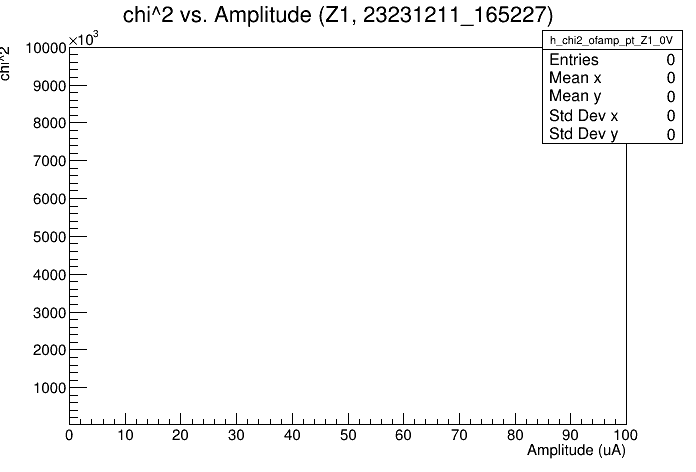

In [10]:
idx = 0
det = 'Z1'
h_chi2_ofamp_pt[idx][det].Draw('colz')
can.Draw()

In [16]:
chan = 'PT'
idx = 1
det = 'Z1'
key = list(series.keys())[idx]
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (TrigDet[idx] == 1)
x = OFamps[series[key]][det][chan][mask]*1e6
y = OFchiq[series[key]][det][chan][mask]

for j in range(len(x)):
    h_chi2_ofamp_pt[idx][det].Fill(x[j],y[j])
    h_chi2_ofamp_pt_zoomed[idx][det].Fill(x[j],y[j])
    if((x[j] < 2) and (x[j] > 1) and (y[j] < 5e4)):
        h_ofamp_pt[idx][det].Fill(x[j])


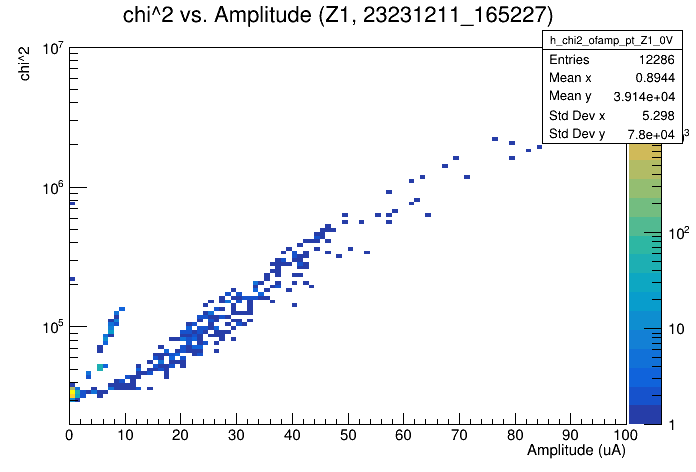

In [19]:
idx = 0
det = 'Z1'
h_chi2_ofamp_pt[idx][det].Draw('colz')
can.Draw()

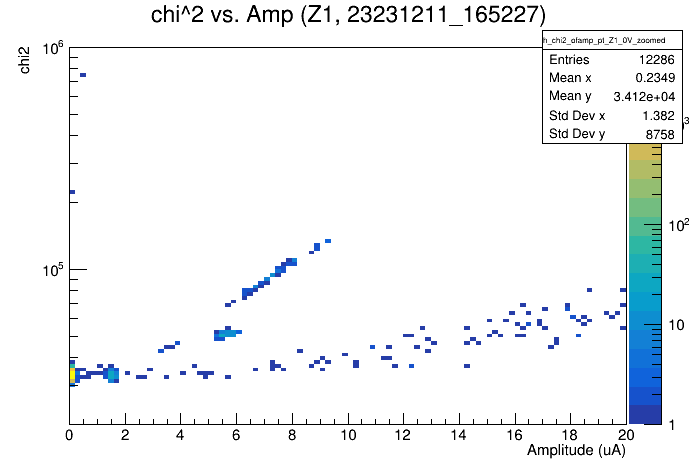

In [20]:
h_chi2_ofamp_pt_zoomed[idx][det].Draw('colz')
can.Draw()

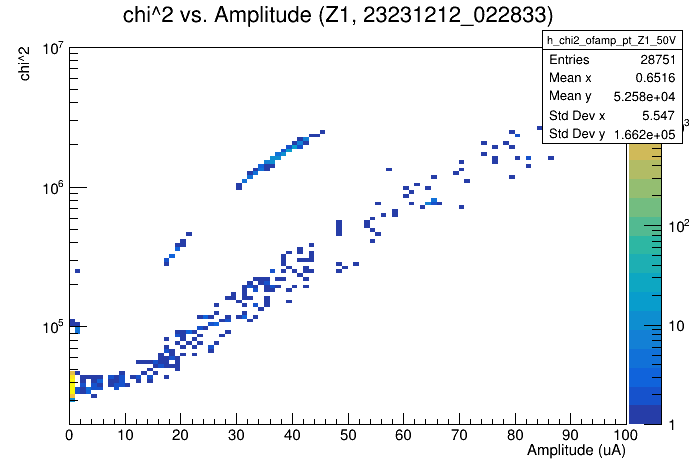

In [21]:
idx = 1
det = 'Z1'
h_chi2_ofamp_pt[idx][det].Draw('colz')
can.Draw()

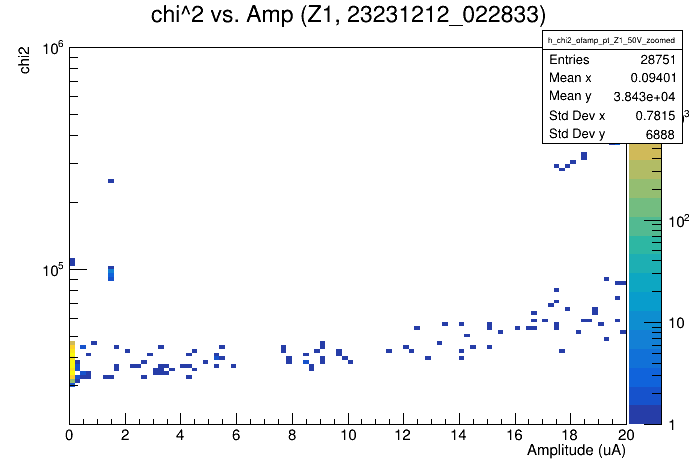

In [22]:
idx = 1
det = 'Z1'
h_chi2_ofamp_pt_zoomed[idx][det].Draw('colz')
can.Draw()

12286
12286


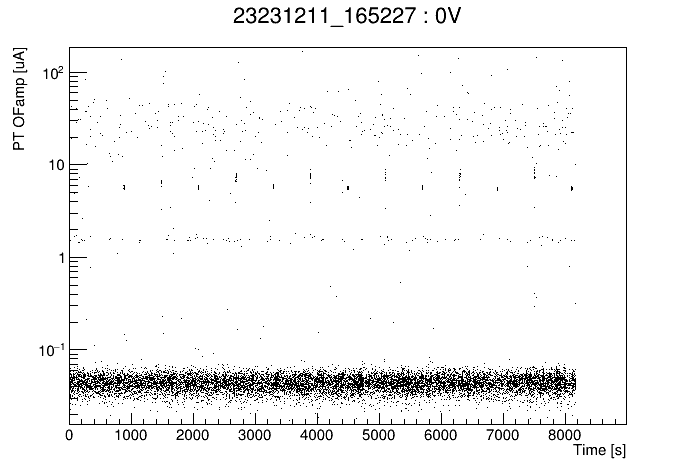

In [27]:
#gr_amp_t = rt.TGraph('gr_amp_t','gr_amp_t',0,10e3)
chan = 'PT'
det = 'Z1'
idx = 0
key = list(series.keys())[idx]
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t = rt.TGraph(len(x),x,y)
gr_amp_t.SetTitle(series[key]+ ' : ' +key )
gr_amp_t.GetXaxis().SetTitle('Time [s]')
gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t.Draw('AP')
can.SetLogy()
can.Draw()
print(len(x))
print(len(y))

28751
28751


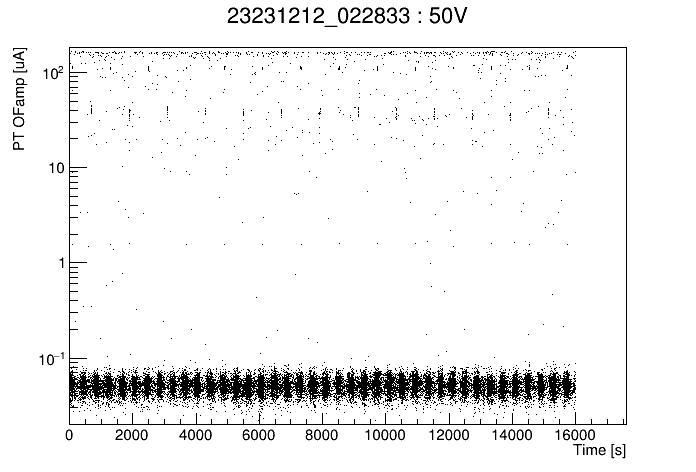

In [28]:
chan = 'PT'
det = 'Z1'
idx = 1
key = list(series.keys())[idx]
mask = (TriggerType[idx] == 1) & (OFamps[series[key]][det][chan] > 0.) & (EventTime[idx] > 0.) & (TrigDet[idx] == 1)
t0 = EventTime[idx][mask][0]
#EventTime[0][mask] - t0

x = EventTime[idx][mask] - t0
y = OFamps[series[key]][det][chan][mask]*1e6
gr_amp_t = rt.TGraph(len(x),x,y)
gr_amp_t.SetTitle(series[key]+ ' : ' +key )
gr_amp_t.GetXaxis().SetTitle('Time [s]')
gr_amp_t.GetYaxis().SetTitle('PT OFamp [uA]')
gr_amp_t.Draw('AP')
can.SetLogy()
can.Draw()
print(len(x))
print(len(y))

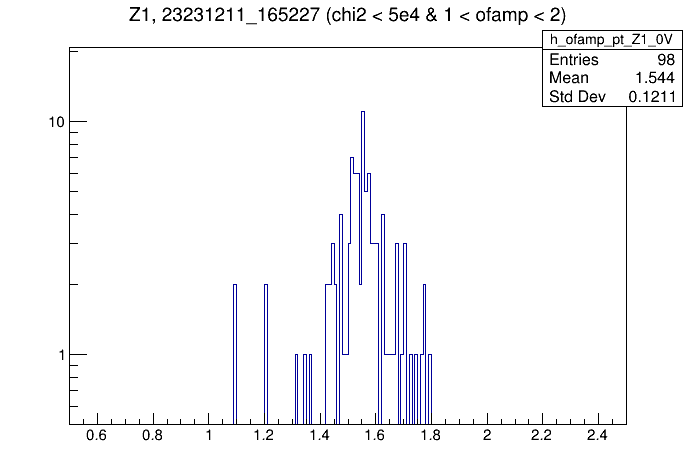

In [31]:
idx = 0
det = 'Z1'
h_ofamp_pt[idx][det].Draw()
can.Draw()

In [32]:
calib_0V = 10.0/1.544 # 
print('std dev = %0.2f'%(0.1211*calib_0V))

std dev = 0.78
